In [1]:
import numpy as np
import random
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import opacus
from opacus.validators import ModuleValidator
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager

SEED = 1024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### simulate points

In [2]:
# multivariate gaussian
f_0 = np.random.multivariate_normal(  # majority of class 0
    mean=[5, 5], cov=[[3, 0], [0, 3]], size=1000
)  
f_1 = np.random.multivariate_normal(  # majority of class 1
    mean=[13, 5], cov=[[3, 0], [0, 3]], size=1000
)
# point mass gaussian
f_0_1 = np.random.multivariate_normal(  # minority of class 1
    mean=[-3, 10], cov=[[1, 0], [0, 1]], size=50
)
f_1_1 = np.random.multivariate_normal(  # minority of class 0
    mean=[23, 0], cov=[[1, 0], [0, 1]], size=50
)

In [3]:
f_0.shape, f_0_1.shape

((1000, 2), (50, 2))

In [4]:
x1_0, x2_0 = np.concatenate([f_0[:, 0], f_1_1[:, 0]]), np.concatenate([f_0[:, 1], f_1_1[:, 1]])  # class 0
x1_1, x2_1 = np.concatenate([f_1[:, 0], f_0_1[:, 0]]), np.concatenate([f_1[:, 1], f_0_1[:, 1]])  # class 1

In [5]:
x1_0.shape, x2_0.shape, x1_1.shape, x2_1.shape

((1050,), (1050,), (1050,), (1050,))

In [6]:
# plt.scatter(x1_0, x2_0, color='blue')
# plt.scatter(x1_1, x2_1, color='red')
# plt.show()

#### center mass and many pairs

In [7]:
n_pairs = 20

In [8]:
f_0 = np.random.multivariate_normal(  # majority of class 0
    mean=[5, 5], cov=[[7, 0], [0, 7]], size=1000
)
f_1 = np.random.multivariate_normal(  # majority of class 1
    mean=[20, 5], cov=[[7, 0], [0, 7]], size=1000
)

In [9]:
tmp_list = []
tmp_label = []
for _ in range(n_pairs):
    tmp_list.append(np.random.multivariate_normal(
        mean=[np.random.uniform(4, 21), np.random.uniform(-15, -4)], cov=[[0.02, 0], [0, 0.02]], size=2
    ))
    tmp_label.extend([np.random.choice([0, 1])] * 2)
    #
    tmp_list.append(np.random.multivariate_normal(
        mean=[np.random.uniform(4, 21), np.random.uniform(-15, -4)], cov=[[0.02, 0], [0, 0.02]], size=2
    ))
    tmp_label.extend([np.random.choice([0, 1])] * 2)
    #
    tmp_list.append(np.random.multivariate_normal(
        mean=[np.random.uniform(4, 21), np.random.uniform(13, 25)], cov=[[0.02, 0], [0, 0.02]], size=2
    ))
    tmp_label.extend([np.random.choice([0, 1])] * 2)
    #
    tmp_list.append(np.random.multivariate_normal(
        mean=[np.random.uniform(4, 21), np.random.uniform(13, 25)], cov=[[0.02, 0], [0, 0.02]], size=2
    ))
    tmp_label.extend([np.random.choice([0, 1])] * 2)
f_0_1 = np.concatenate(tmp_list, axis=0)
tmp_label = np.array(tmp_label)

In [10]:
f_0_1.shape, tmp_label.shape

((160, 2), (160,))

In [11]:
# plt.scatter(f_0[:, 0], f_0[:, 1], color='blue')
# plt.scatter(f_1[:, 0], f_1[:, 1], color='red')
# plt.scatter(f_0_1[:, 0], f_0_1[:, 1], color='green')
# plt.show()

In [12]:
x1_0, x2_0 = np.concatenate([f_0[:, 0], f_0_1[np.where(tmp_label == 0)[0], 0]]), np.concatenate([f_0[:, 1], f_0_1[np.where(tmp_label == 0)[0], 1]])  # class 0
x1_1, x2_1 = np.concatenate([f_1[:, 0], f_0_1[np.where(tmp_label == 1)[0], 0]]), np.concatenate([f_1[:, 1], f_0_1[np.where(tmp_label == 1)[0], 1]])  # class 1

In [13]:
x1_0.shape, x2_0.shape, x1_1.shape, x2_1.shape

((1074,), (1074,), (1086,), (1086,))

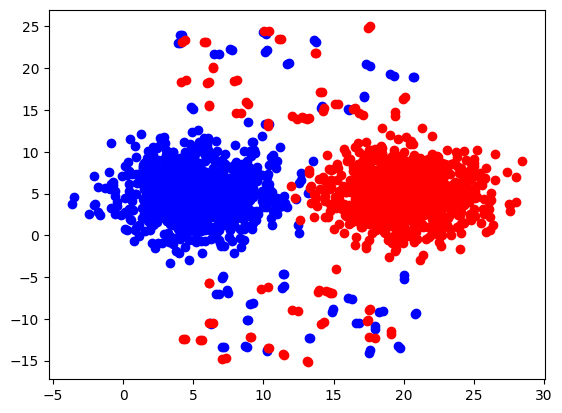

In [14]:
plt.scatter(x1_0, x2_0, color='blue')
plt.scatter(x1_1, x2_1, color='red')
plt.show()

In [15]:
all_x1 = np.concatenate([x1_0, x1_1])
all_x2 = np.concatenate([x2_0, x2_1])
all_y = np.concatenate([np.zeros(len(x1_0)), np.ones(len(x1_1))]).astype(int)

In [32]:
outlier_indicator = np.array([0] * f_0[:, 0].shape[0] + [1] * f_0_1[np.where(tmp_label == 0)[0], 0].shape[0] + \
                             [0] * f_1[:, 0].shape[0] + [1] * f_0_1[np.where(tmp_label == 1)[0], 0].shape[0])

In [28]:
all_x1.shape, all_x2.shape, all_y.shape

((2160,), (2160,), (2160,))

In [33]:
outlier_indicator.shape

(2160,)

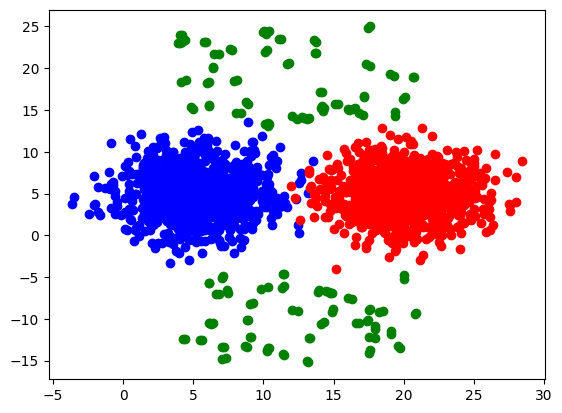

In [43]:
plt.scatter(all_x1[np.where((all_y == 0) & (outlier_indicator == 0))[0]], 
            all_x2[np.where((all_y == 0) & (outlier_indicator == 0))[0]], color='blue')
plt.scatter(all_x1[np.where((all_y == 1) & (outlier_indicator == 0))[0]], 
            all_x2[np.where((all_y == 1) & (outlier_indicator == 0))[0]], color='red')
plt.scatter(all_x1[np.where(outlier_indicator == 1)[0]], 
            all_x2[np.where(outlier_indicator == 1)[0]], color='green')
plt.show()

#### create dataset

In [52]:
all_x1 = np.concatenate([x1_0, x1_1])
all_x2 = np.concatenate([x2_0, x2_1])
all_y = np.concatenate([np.zeros(len(x1_0)), np.ones(len(x1_1))]).astype(int)

In [53]:
len(all_x1), len(all_x2), len(all_y)

(2160, 2160, 2160)

In [54]:
dat = pd.DataFrame({'x1': all_x1, 'x2': all_x2, 'y': all_y})

In [55]:
dat.head()

,x1,x2,y
0,12.695067,7.506619,0
1,8.867220,4.999865,0
2,5.076529,6.755821,0
3,4.572927,7.597095,0
4,2.565994,2.657738,0


In [56]:
dat['tmp_index'] = dat.index

In [57]:
x_data = torch.tensor(dat[['x1', 'x2', 'tmp_index']].values, dtype=torch.float32)
y_data = torch.tensor(dat[['y', 'tmp_index']].values, dtype=torch.long)

In [58]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, random_state=SEED, test_size=0.5, shuffle=True)

In [64]:
x_valid

tensor([[  16.2225,    5.5560, 1778.0000],
        [  19.9595,    5.4694, 1987.0000],
        [  16.1860,    6.5901, 1927.0000],
        ...,
        [   3.6601,    3.9194,  173.0000],
        [  22.7428,    8.6713, 2027.0000],
        [  21.2822,    3.7072, 1294.0000]])

#### model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
N_DIM = 2
N_CLASS = 2

# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(N_DIM, 32)
#         self.linear2 = nn.Linear(32, 64)
#         self.linear3 = nn.Linear(64, 32)
#         self.linear4 = nn.Linear(32, N_CLASS)
#         self.relu = nn.ReLU()
#         # self.dropout = nn.Dropout(p=0.25)
#     def forward(self, x):
#         return self.linear4(self.relu(self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))))
# model = MLP().to(device)

model = nn.Sequential(
    nn.Linear(N_DIM, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, N_CLASS)
)
model = model.to(device)

In [ ]:
model

In [ ]:
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR)

#### non-priv train

In [ ]:
def np_to_torch(x):
    return torch.from_numpy(x).to(torch.float32).to(device)

def torch_to_np(x):
    return x.cpu().detach().numpy()

In [ ]:
def accuracy(preds, labels):
    return (torch_to_np(preds) == torch_to_np(labels)).mean()

In [ ]:
EPOCHS = 10000
EVAL_EVERY = 100

x_train, x_valid = x_train.to(device), x_valid.to(device)
y_train, y_valid = y_train.to(device), y_valid.to(device)

step_counter = 0
train_loss_values, valid_loss_values = [], []

for epoch in tqdm(range(EPOCHS + 1)):

    model.train()

    y_logits = model(x_train)
    loss = loss_fn(y_logits, y_train.flatten())
    _, y_pred = torch.max(y_logits, 1)
    acc = accuracy(y_pred, y_train.flatten())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    step_counter += 1
    
    if step_counter % EVAL_EVERY == 0:    
        model.eval()
        with torch.inference_mode():
            valid_logits = model(x_valid)
            valid_loss = loss_fn(valid_logits, y_valid.flatten())
            _, valid_pred = torch.max(valid_logits, 1)
            valid_acc = accuracy(valid_pred, y_valid.flatten())
            
        print(f'Epoch: {epoch:4.0f} | Step: {step_counter:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')
        train_loss_values.append(loss.detach().cpu().numpy())
        valid_loss_values.append(valid_loss.detach().cpu().numpy())

#### priv train

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset))

In [ ]:
MAX_GRAD_NORM = 1.0
EPSILON = 5.0
DELTA = 1e-5
# BATCH_SIZE = 512
# MAX_PHYSICAL_BATCH_SIZE = 128
MAX_PHYSICAL_BATCH_SIZE = len(train_dataset)
EPOCHS = 300

In [ ]:
model_priv = ModuleValidator.fix(model)

In [ ]:
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_priv.parameters(), lr=LR)

In [ ]:
privacy_engine = PrivacyEngine()

model_priv, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model_priv,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

In [ ]:
step_counter = 0

for epoch in tqdm(range(EPOCHS + 1)):
    
    model_priv.train()

    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        
         for i, (x_train, y_train) in enumerate(memory_safe_data_loader): 
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            y_logits = model_priv(x_train)
            loss = loss_fn(y_logits, y_train.flatten())
            _, y_pred = torch.max(y_logits, 1)
            acc = accuracy(y_pred, y_train.flatten())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            step_counter += 1
            
            if step_counter % EVAL_EVERY == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                model_priv.eval()
                with torch.inference_mode():
                    for x_valid, y_valid in valid_loader:
                        x_valid = x_valid.to(device)
                        y_valid = y_valid.to(device) 
                        
                        valid_logits = model_priv(x_valid)
                        valid_loss = loss_fn(valid_logits, y_valid.flatten())
                        _, valid_pred = torch.max(valid_logits, 1)
                        valid_acc = accuracy(valid_pred, y_valid.flatten())

                print(f'Epoch: {epoch:4.0f} | Step: {step_counter:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}% | Eps: {epsilon:.2f}')

#### plot

In [ ]:
def infer(xinfer, model):
    model.eval()
    with torch.no_grad():
        ylogits = model(xinfer)
        _, yinfer = torch.max(ylogits, 1)
    return yinfer

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

## non-priv model
xlin1 = np.linspace(round(torch_to_np(x_train[:, 0]).min()) - 2, round(torch_to_np(x_train[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_train[:, 1]).min()) - 2, round(torch_to_np(x_train[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax1.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 0]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 1]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax1.set_title('non_priv_train')
# ax1.legend(loc='lower left', framealpha=.5, fontsize=10)

## priv model
xlin1 = np.linspace(round(torch_to_np(x_train[:, 0]).min()) - 2, round(torch_to_np(x_train[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_train[:, 1]).min()) - 2, round(torch_to_np(x_train[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model_priv)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax2.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 0]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 1]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax2.set_title('priv_train')
# ax2.legend(loc='lower left', framealpha=.5, fontsize=10)

plt.show()
plt.close()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

## non-priv model
xlin1 = np.linspace(round(torch_to_np(x_valid[:, 0]).min()) - 2, round(torch_to_np(x_valid[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_valid[:, 1]).min()) - 2, round(torch_to_np(x_valid[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax1.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 0]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 1]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax1.set_title('non_priv_test')
# ax1.legend(loc='lower left', framealpha=.5, fontsize=10)

## priv model
xlin1 = np.linspace(round(torch_to_np(x_valid[:, 0]).min()) - 2, round(torch_to_np(x_valid[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_valid[:, 1]).min()) - 2, round(torch_to_np(x_valid[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model_priv)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax2.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 0]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 1]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax2.set_title('priv_test')
# ax2.legend(loc='lower left', framealpha=.5, fontsize=10)

plt.show()
plt.close()